# **A Monte Carlo simulation to study magnetization in the 3D Ising model**
20/06/2025

Claudia Brambilla - 3199479 \\
Mattea Busato - 3218810

# Introduction

The Ising model is a fundamental model in statistical mechanics used to describe ferromagnetism. It consists of discrete variables called *spins* that can take on one of two values: +1 or -1. These spins are arranged on a lattice, and their interactions are used to model phase transitions, such as the transition between magnetic and non-magnetic states in materials.

While the 2D Ising model has an exact solution and has been extensively studied, the **3D Ising model** remains a topic of significant research interest due to the absence of an exact solution and the computational challenges it presents. Its study helps us better understand real-world systems where interactions occur in three dimensions.



## Project Objective


The goal of this project is to **simulate the 3D Ising model using the Metropolis Monte Carlo algorithm** and to analyze how the system's **magnetization** changes as a function of temperature for different lattice sizes.

In physical systems such as the Ising model there can occur a phenomenon called **phase transition** which is a sudden change in the macroscopic behavior of the system driven by variations in external parameters — most commonly, temperature. For example, a ferromagnetic material undergoes a transition from an **ordered phase**, where most spins are aligned and magnetization is non-zero, to a **disordered phase**, where spins are randomly oriented and the net magnetization vanishes. This transformation occurs at a specific point known as the **critical temperature** ($T_c$), and is accompanied by characteristic signatures such as diverging susceptibility and large fluctuations.

This simulation allows us to investigate the nature of such phase transitions and the effect of system size on critical behavior by examining how observable quantities evolve near the critical point.

Specifically, we will:
- Implement a 3D Ising model simulation from scratch.
- Explore a temperature range \( T $\in$ [1.0, 6.0] \) to capture both ordered and disordered phases.
- Study the behavior of magnetization for various lattice sizes (L = 10, 20, 30).
- Analyze thermal fluctuations and compute quantities like magnetic susceptibility and the Binder cumulant.
- Estimate the critical temperature and assess how finite-size effects influence the sharpness of the transition.



This notebook aims to provide a step-by-step exploration of the 3D Ising model, using well-documented code, clear visualizations, and comprehensive analysis.

# Simulation Setup

In this section, we outline the implementation details of our simulation. We begin by defining the 3D lattice structure and the relevant physical quantities to be measured, such as magnetization, energy, susceptibility, and the Binder cumulant. We then describe the Monte Carlo algorithm used to evolve the system — specifically, the Metropolis method — and set the simulation parameters such as lattice sizes, temperature range, and number of Monte Carlo steps. This setup forms the foundation for the numerical experiments conducted later in the notebook.

## Libraries

In [23]:
import os

import numpy as np
import imageio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image

## The lattice

The Ising model is defined on a lattice where each site hosts a spin variable $s_i \in \{-1, +1\}$. These spins interact with their nearest neighbors, and the total energy of the system depends on the configuration of these pairwise interactions.

In the 3D version of the model, the lattice is a cubic grid of size $L \times L \times L$. Each spin interacts with up to six nearest neighbors — those located in the adjacent positions along the $x$, $y$, and $z$ directions (i.e., left/right, up/down, front/back). This structure captures the geometry of real-world 3D systems and increases the complexity of the simulation compared to the 1D or 2D versions of the model.


In [4]:
def initialize_lattice(L):
    """
    Initialize a 3D Ising lattice of size LxLxL with random spins (+1 or -1).

    Parameters:
        L (int): Size of the lattice (cube dimension)

    Returns:
        lattice (ndarray): 3D numpy array with shape (L, L, L)
    """
    lattice = np.random.choice([-1, 1], size=(L, L, L))
    return lattice

In [5]:
def visualize_lattice(lattice, filename=None):
    """
    Visualize a 3D Ising lattice using a 3D scatter plot.

    Parameters:
        lattice (ndarray): A 3D NumPy array of shape (L, L, L), where each element
                           is either +1 (spin up) or -1 (spin down).
        filename (str, optional): If provided, the plot is saved to this filename.
                                  Otherwise, the plot is displayed interactively.

    Description:
        This function creates a 3D scatter plot of the lattice, coloring spin-up
        sites in red and spin-down sites in blue. It is useful for visual inspection
        of spin configurations at different stages of the simulation.
    """
    L = lattice.shape[0]
    x, y, z = np.indices((L, L, L))

    pos_plus = (lattice == 1)
    pos_minus = (lattice == -1)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[pos_plus], y[pos_plus], z[pos_plus], color='red', s=20, label='+1 spins')
    ax.scatter(x[pos_minus], y[pos_minus], z[pos_minus], color='blue', s=20, label='-1 spins')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('3D Ising Lattice Visualization')

    if filename:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

For example, here we plot a randomly initialized lattice of size $L = 15$ which produces a 3D scatter plot with red and blue points distributed uniformly throughout the cube, representing spin-up and spin-down states respectively.


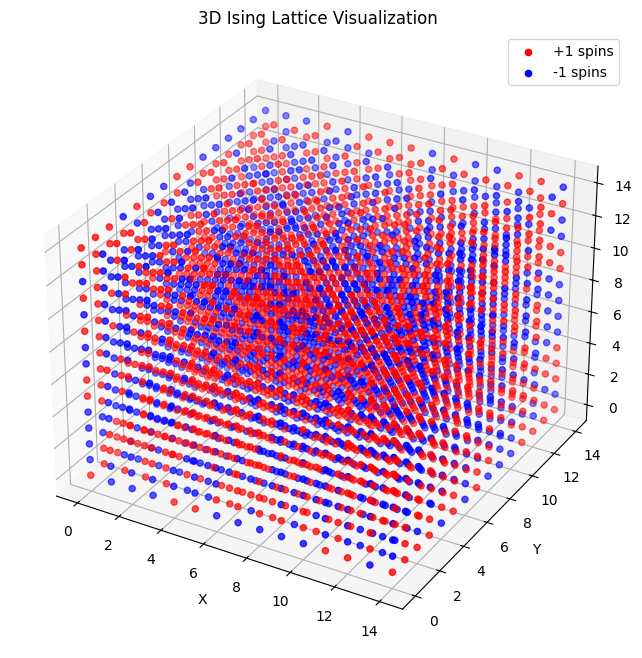

In [19]:
L = 15
lattice = initialize_lattice(L)
visualize_lattice(lattice)

## Quantities of interest

To understand the thermodynamic behavior of the 3D Ising model and detect the presence of a phase transition, we analyze several key physical quantities derived from the spin configurations. These observables help characterize the system's macroscopic state and how it evolves with temperature.

Together, these quantities allow us to track the onset of long-range order and estimate the location and nature of the phase transition.


### Energy

The energy of a configuration is described by the **Hamiltonian**:

$$
H = -J \sum_{\langle i,j \rangle} s_i s_j - h \sum_i s_i
$$

- $J$: interaction strength (positive for ferromagnetic coupling).  
- $\langle i,j \rangle$: sum over nearest-neighbor pairs.  
- $h$: external magnetic field.  
- $s_i$: spin at site $i$, either +1 or -1.

We will use the common assumptions:  
- $J = 1$ (ferromagnetic coupling)  
- $h = 0$ (no external magnetic field)  
- $k_B = 1$ (Boltzmann constant)

These assumptions are commonly adopted in simulations because they simplify the model without affecting the universality of the results. Setting $J = 1$ simply fixes the energy scale of the system, while $k_B = 1$ sets the temperature scale, allowing us to express all quantities in natural units. Likewise, choosing $h = 0$ eliminates the influence of an external field, focusing the analysis purely on the intrinsic behavior of the system. These choices do not alter the qualitative features of the model — in particular, the nature of the phase transition and critical behavior remain unchanged — making the results broadly generalizable.


In [7]:
def compute_total_energy(lattice, J=1):
    """
    Compute the total energy of a 3D Ising lattice with periodic boundary conditions.

    Parameters:
        lattice (ndarray): 3D numpy array with spin values (+1 or -1)
        J (float): interaction constant (default 1)

    Returns:
        Total energy (float)
    """
    L = lattice.shape[0]
    energy = 0.0

    for i in range(L):
        for j in range(L):
            for k in range(L):
                spin = lattice[i, j, k]
                # Only count each neighbor pair once (avoid double-counting)
                neighbors = (
                    lattice[(i+1)%L, j, k] +
                    lattice[i, (j+1)%L, k] +
                    lattice[i, j, (k+1)%L]
                )
                energy -= J * spin * neighbors

    return energy

### Magnetization

The **magnetization** quantifies the degree of alignment of the spins:
$$
M = \frac{1}{N} \sum_i s_i
$$

A sharp change in magnetization around the critical temperature indicates a phase transition: in the low-temperature regime, spins tend to align, resulting in non-zero magnetization (ordered phase), while at high temperatures, thermal fluctuations dominate and the average magnetization drops to zero (disordered phase).

Since the Ising model has a $\mathbb{Z}_2$ symmetry (i.e., the Hamiltonian is invariant under flipping all spins), the system has two equivalent ordered states with opposite magnetization. As a result, the raw magnetization may average out to zero even below $T_c$ due to symmetry-breaking fluctuations. To avoid this, we track the **absolute value** of the magnetization, which captures the degree of order regardless of the sign.

This transition from order to disorder occurs at a well-defined **critical temperature** $T_c$. In the 3D Ising model, $T_c$ is not known analytically, but numerical studies suggest it is approximately:
$$
T_c \approx 4.5 \quad \text{(in units where } J = k_B = 1 \text{)}
$$

By tracking how magnetization changes with temperature for different system sizes, we can detect the onset of spontaneous symmetry breaking and estimate the critical temperature. In particular, the transition becomes sharper as the lattice size increases, providing a clearer signal of the phase transition in the thermodynamic limit.


In [8]:
def compute_magnetization(lattice):
    """
    Compute the absolute magnetization per spin of a 3D Ising lattice.

    Parameters:
        lattice (ndarray): A 3D NumPy array containing spin values (+1 or -1).

    Returns:
        float: The absolute value of the total magnetization divided by the
               number of spins, representing the average magnetization per spin.
    """
    return np.abs(np.sum(lattice)) / lattice.size

### Magnetic Susceptibility

The **magnetic susceptibility** measures how strongly the magnetization responds to small changes in an external magnetic field. In the absence of a field, it can also be interpreted as a measure of fluctuations in magnetization:

$$
\chi = \frac{1}{k_B T} \left( \langle M^2 \rangle - \langle M \rangle^2 \right)
$$

Near the critical temperature, the system becomes highly sensitive to thermal fluctuations, resulting in large variations in magnetization even without any external influence. As a consequence, $\chi$ exhibits a pronounced **peak at the critical temperature**, making it a valuable indicator for locating the phase transition. The height and sharpness of this peak also increase with lattice size, reflecting the growing correlation length in the system.


In [9]:
def compute_susceptibility(magnetizations, T):
    """
    Compute the magnetic susceptibility from a list of magnetization values.

    Parameters:
        magnetizations (list or ndarray): magnetization values (can be signed or absolute)
        T (float): temperature at which the measurements were taken

    Returns:
        chi (float): magnetic susceptibility
    """
    magnetizations = np.array(magnetizations)
    M_squared_avg = np.mean(magnetizations**2)
    M_avg = np.mean(np.abs(magnetizations))  # Use abs for broken symmetry
    chi = (M_squared_avg - M_avg**2) / T
    return chi

### Binder Cumulant

The **Binder cumulant** is a dimensionless quantity constructed from higher-order moments of the magnetization:

$$
U_4 = 1 - \frac{\langle M^4 \rangle}{3 \langle M^2 \rangle^2}
$$

Unlike quantities that depend on system size or energy scale, the Binder cumulant has the useful property of being nearly **independent of lattice size at the critical temperature**. This makes it especially effective for detecting phase transitions in finite systems.

By plotting $U_4$ as a function of temperature for different values of $L$, the curves for each lattice size intersect at a common point. This **crossing point** provides a robust numerical estimate of the **critical temperature** $T_c$, with minimal influence from finite-size effects. As a result, the Binder cumulant is widely used in Monte Carlo studies of critical phenomena.


In [ ]:
def compute_binder_cumulant(magnetizations):
    """
    Compute the Binder cumulant from a list of magnetization values.

    Parameters:
        magnetizations (list or ndarray): list of magnetization values (per spin)

    Returns:
        U (float): Binder cumulant
    """
    magnetizations = np.abs(np.array(magnetizations))  # Use abs to reflect symmetry
    M2 = np.mean(magnetizations**2)
    M4 = np.mean(magnetizations**4)

    if M2 == 0:
        return np.nan  # Avoid division by zero

    U = 1 - (M4 / (3 * M2**2))
    return U


## Metropolis algorithm

We simulate the 3D Ising model using the **Metropolis Monte Carlo algorithm**, a widely-used technique to generate equilibrium configurations of spin systems. This method is particularly effective for studying critical phenomena in systems with many degrees of freedom.

The main idea of the algorithm is to update the spin configuration by accepting or rejecting spin flips based on the Boltzmann distribution. The steps are:

1. **Initialize** the 3D lattice with random spin values $s_i \in \{-1, +1\}$.
2. **Sweep** through the lattice:
   - Select a spin at random.
   - Compute the energy change $\Delta E$ from flipping that spin
   - Accept the flip if $\Delta E \leq 0$, otherwise accept it with probability $e^{-\Delta E/T}$.
3. **Repeat** the sweeps for a number of steps.
4. **Measure** observables like magnetization and susceptibility.

The function `metropolis_step` implements a **single spin-flip attempt**, randomly selecting a spin, calculating the energy change, and applying the Metropolis acceptance criterion. However, a single step only updates one spin, and thus has a very limited effect on the system.

To allow the entire lattice to evolve toward equilibrium, we define a **Monte Carlo sweep** via the `metropolis_sweep` function. One sweep consists of $L^3$ spin-flip attempts — one for each lattice site on average — representing a full pass over the system. Performing multiple sweeps is essential for reaching thermal equilibrium and for collecting statistically meaningful measurements of observables.



In [2]:
def metropolis_step(lattice, T, J=1):
    """
    Perform a single Metropolis update using full energy difference via compute_total_energy.

    Parameters:
        lattice (ndarray): 3D numpy array with spin values (+1 or -1)
        T (float): temperature
        J (float): interaction constant (default 1)

    Returns:
        delta_E (float): actual energy difference (E_after - E_before)
        delta_M (int): change in magnetization
    """
    L = lattice.shape[0]

    # Choose a random spin
    i = np.random.randint(0, L)
    j = np.random.randint(0, L)
    k = np.random.randint(0, L)

    spin = lattice[i, j, k]

    # Compute energy before flipping
    E_before = compute_total_energy(lattice, J)

    # Propose the flip
    lattice[i, j, k] *= -1

    # Compute energy after flipping
    E_after = compute_total_energy(lattice, J)

    delta_E = E_after - E_before
    delta_M = -2 * spin  # If flip accepted, this is the change in magnetization

    # Metropolis criterion
    if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / T):
        # Flip accepted
        return delta_E, delta_M
    else:
        # Flip rejected — undo flip
        lattice[i, j, k] *= -1
        return 0.0, 0  # No change


In [1]:
def metropolis_sweep(lattice, T, J=1):
    """
    Perform a single Monte Carlo sweep using the Metropolis algorithm.

    Parameters:
        lattice (ndarray): A 3D NumPy array representing the spin lattice
                           with values (+1 or -1).
        T (float): Temperature of the system.
        J (float): Interaction strength (default is 1 for ferromagnetic coupling).

    Description:
        A sweep consists of L^3 Metropolis steps, where L is the lattice side length.
        This corresponds to one attempted spin update per lattice site on average,
        allowing the entire system to evolve toward equilibrium.
    """
    L = lattice.shape[0]
    for _ in range(L**3):
        metropolis_step(lattice, T, J)

## Function for visualization

To complement our quantitative analysis, we include a function `create_gif` that generates an animated visualization of the spin lattice as it evolves over time. This function collects a sequence of PNG images (typically saved during the simulation at regular intervals) and compiles them into a GIF that shows the dynamic behavior of the system.

Visualizing the **temporal evolution** of the Ising model helps develop intuition about the dynamics of spin alignment, the role of temperature, and how long-range order emerges (or disappears) as the system approaches equilibrium. At low temperatures, one can observe the gradual formation of large magnetized domains, while at high temperatures, the lattice remains disordered due to thermal fluctuations.


In [15]:
def create_gif(num_frames, output_filename='ising_3D.gif'):
    with imageio.get_writer(output_filename, mode='I', duration=0.5) as writer:
        for idx in range(num_frames):
            filename = f"frame_{idx:03d}.png"
            image = imageio.imread(filename)
            writer.append_data(image)
    print(f"GIF saved as {output_filename}")

The following example demonstrates how the Metropolis algorithm updates the spin configuration of the lattice at a given temperature.


In [21]:
L = 10
T = 3.0
total_steps = 100000
snapshot_interval = 500

lattice = initialize_lattice(L)
snapshots = []

for step in range(total_steps):
    metropolis_step(lattice, T)
    if step % snapshot_interval == 0:
        snapshots.append(lattice.copy())

for idx, lattice_snapshot in enumerate(snapshots):
    filename = f"frame_{idx:03d}.png"
    visualize_lattice(lattice_snapshot, filename=filename)

create_gif(len(snapshots), output_filename='ising_3D.gif')

/tmp/ipython-input-15-2792560315.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as ising_3D.gif


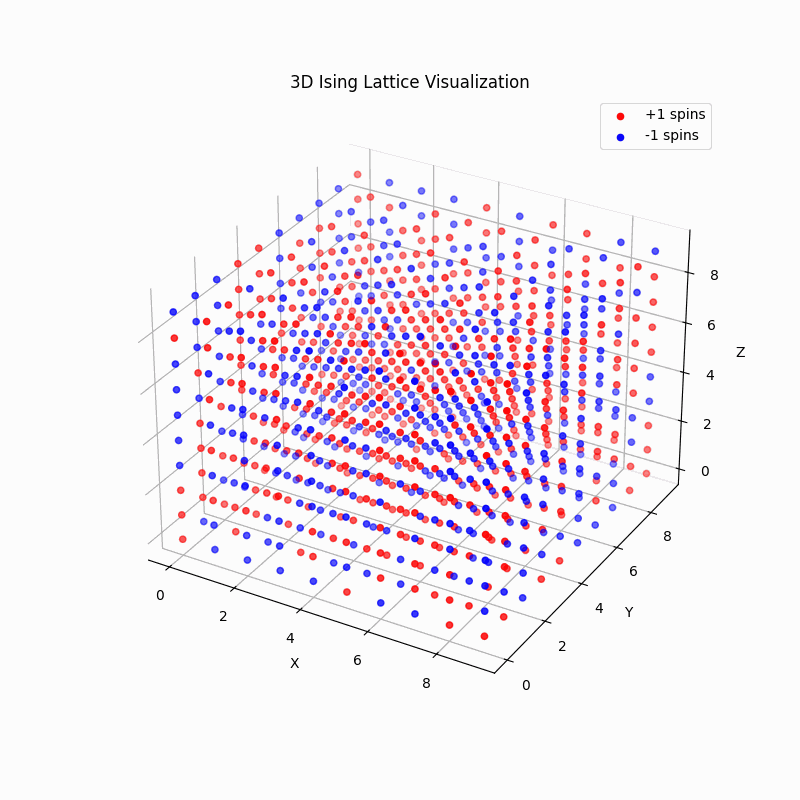

In [24]:
display(Image(filename="ising_3D.gif"))

# Simulations

In this section, we carry out numerical simulations of the 3D Ising model to study how thermodynamic observables evolve with temperature. By performing Monte Carlo sweeps using the Metropolis algorithm, we generate equilibrium configurations of the spin lattice for various temperatures and system sizes. Our goal is to analyze the behavior of magnetization, susceptibility, and the Binder cumulant across a range of temperatures in order to identify and characterize the phase transition.

We run the simulations with combinations of the following parameters:
- **Lattice shape:** cubic ($L \times L \times L$)
- **Lattice sizes:** $L = 10, 20, 30$ (larger sizes like 150–250 were used in literature)
- **Temperature range:** $T \in [1.0, 6.0]$
- **Monte Carlo sweeps:** 1000 per temperature (no separate equilibration phase in this stage)
- **Independent simulations:** repeated multiple times to average results

The focus is to examine how magnetization and susceptibility vary with temperature, and to use Binder cumulant analysis to **estimate the critical temperature $T_c \approx 4.5$**.



In [ ]:
def simulate_ising(L, T, steps=1000, J=1):
    """
    Run an Ising model simulation and record magnetization, energy, susceptibility, and Binder cumulant.

    Parameters:
        L (int): lattice size (LxLxL cube)
        T (float): temperature
        steps (int): number of total Monte Carlo sweeps (also used for measurements)
        J (float): interaction constant

    Returns:
        results (dict): dictionary with average and std of energy, magnetization, susceptibility, and Binder cumulant
    """
    lattice = initialize_lattice(L)
    N = L**3  # Total number of spins

    energies = []
    magnetizations = []

    for _ in range(steps):
        metropolis_sweep(lattice, T, J)
        E = compute_total_energy(lattice, J) / N  # normalize per spin
        M = compute_magnetization(lattice)     # signed magnetization per spin

        energies.append(E)
        magnetizations.append(M)

    # Compute derived quantities
    avg_E = np.mean(energies)
    std_E = np.std(energies)

    avg_M = np.mean(np.abs(magnetizations))  # usually use abs for symmetry
    std_M = np.std(magnetizations)

    chi = compute_susceptibility(magnetizations, T)
    binder = compute_binder_cumulant(magnetizations)

    return {
        'avg_energy': avg_E,
        'std_energy': std_E,
        'avg_magnetization': avg_M,
        'std_magnetization': std_M,
        'susceptibility': chi,
        'binder_cumulant': binder,
        'energies': energies,
        'magnetizations': magnetizations
    }

L=10, T=1.00, M=1.000
L=10, T=1.26, M=1.000
L=10, T=1.53, M=0.200
L=10, T=1.79, M=0.998
L=10, T=2.05, M=0.994
L=10, T=2.32, M=0.987
L=10, T=2.58, M=0.976
L=10, T=2.84, M=0.959
L=10, T=3.11, M=0.937
L=10, T=3.37, M=0.902
L=10, T=3.63, M=0.855
L=10, T=3.89, M=0.791
L=10, T=4.16, M=0.684
L=10, T=4.42, M=0.471
L=10, T=4.68, M=0.206
L=10, T=4.95, M=0.124
L=10, T=5.21, M=0.076
L=10, T=5.47, M=0.079
L=10, T=5.74, M=0.073
L=10, T=6.00, M=0.063
L=15, T=1.00, M=1.000
L=15, T=1.26, M=1.000
L=15, T=1.53, M=0.999
L=15, T=1.79, M=0.997
L=15, T=2.05, M=0.994
L=15, T=2.32, M=0.987
L=15, T=2.58, M=0.975
L=15, T=2.84, M=0.960
L=15, T=3.11, M=0.236
L=15, T=3.37, M=0.902
L=15, T=3.63, M=0.856
L=15, T=3.89, M=0.789
L=15, T=4.16, M=0.682
L=15, T=4.42, M=0.486
L=15, T=4.68, M=0.124
L=15, T=4.95, M=0.062
L=15, T=5.21, M=0.040
L=15, T=5.47, M=0.043
L=15, T=5.74, M=0.045
L=15, T=6.00, M=0.033
L=20, T=1.00, M=1.000
L=20, T=1.26, M=1.000
L=20, T=1.53, M=0.967
L=20, T=1.79, M=0.997
L=20, T=2.05, M=0.994
L=20, T=2.

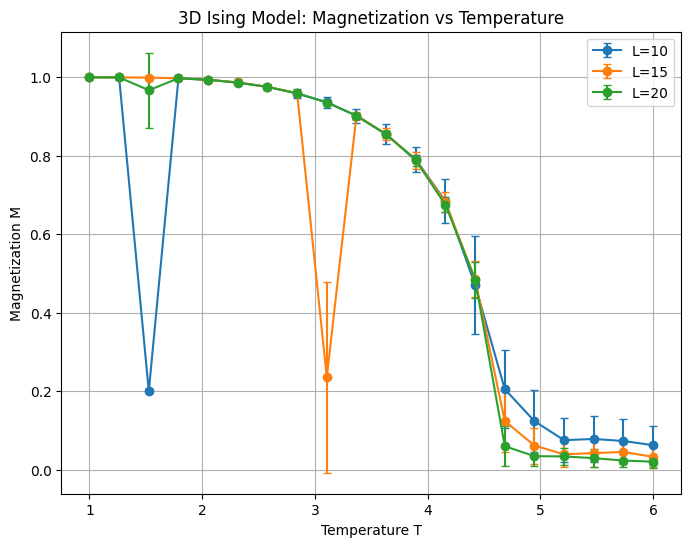

In [ ]:
def run_full_simulation(L_values, T_values):
    """
    Run the 3D Ising model simulation over multiple lattice sizes and temperatures.

    For each combination of lattice size (L) and temperature (T), this function:
    - Runs a Monte Carlo simulation to estimate average magnetization.
    - Collects standard deviations to estimate statistical error.
    - Prints the results for each run.
    - Stores magnetization and corresponding error in a dictionary indexed by lattice size.

    Parameters:
        L_values (list of int): List of lattice sizes to simulate (e.g., [10, 15, 20]).
        T_values (list or array of float): List of temperatures to sweep over.

    Returns:
        results (dict): Dictionary where each key is a lattice size L and the value is a tuple:
                        (array of average magnetizations, array of standard deviations),
                        both of length equal to len(T_values).
    """
    results = {}

    for L in L_values:
        mags = []
        errors = []
        for T in T_values:
            mean_mag, std_mag = simulate_ising(L, T)
            mags.append(mean_mag)
            errors.append(std_mag)
            print(f"L={L}, T={T:.2f}, M={mean_mag:.3f}")
        results[L] = (np.array(mags), np.array(errors))

    return results

L_values = [10, 15, 20]
T_values = np.linspace(1, 6, 20)

results = run_full_simulation(L_values, T_values)

plt.figure(figsize=(8,6))

for L in L_values:
    mags, errors = results[L]
    plt.errorbar(T_values, mags, yerr=errors, label=f'L={L}', capsize=3, fmt='-o')

plt.xlabel('Temperature T')
plt.ylabel('Magnetization M')
plt.title('3D Ising Model: Magnetization vs Temperature')
plt.legend()
plt.grid()
plt.show()

This plot shows the results of simulations performed across a range of lattice sizes ($L = 10, 15, 20$) and temperatures spanning $T \in [1.0, 6.0]$.
 For each $(L, T)$ pair, it performs 1000 Monte Carlo sweeps using the Metropolis algorithm to estimate the average magnetization per spin and its standard deviation. No thermalization steps were included in this run. The error bars reflect statistical fluctuations across sweeps. The magnetization curves exhibit behavior characteristic of the 3D Ising model:

- At low temperatures ($T < 3$), the magnetization is close to 1, indicating strong spontaneous magnetization (ordered phase).
- As temperature increases, a sharp drop in magnetization occurs around $T \approx 4.5$, signaling the ferromagnetic-to-paramagnetic phase transition.
- For $T > 5$, the magnetization approaches zero, as thermal fluctuations dominate (disordered phase).
- The transition becomes sharper with increasing lattice size, consistent with finite-size scaling theory.
- Sudden dips (e.g., at $T = 1.5$ or $T = 3$ for smaller $L$) are likely artifacts due to insufficient equilibration or sampling noise in the absence of thermalization.

## Focused Simulations Near the Critical Region

To more accurately investigate critical behavior near the transition point, we perform two additional sets of simulations on smaller lattice sizes ($L = 6, 8, 10$) over a refined temperature range $T \in [3.0, 6.0]$, where the critical region is expected. These reduced system sizes are chosen to accelerate computation while still capturing the relevant thermodynamic behavior. The first set of simulations is conducted without discarding thermalization steps, while the second includes a thermalization phase before measurements.

We focus on three key quantities: **average magnetization**, **magnetic susceptibility**, and the **Binder cumulant**, which is particularly useful for estimating $T_c$ independent of system size.



### Simulation 1: Without Thermalization

These simulations do not include a thermalization phase: measurements begin immediately after initialization.

This setup allows us to rapidly assess how key observables vary with temperature, though it may involve sampling from non-equilibrated states. The aim is to examine whether meaningful signatures of the phase transition can still be observed under these simplified conditions.


=== Simulating for L = 6 ===
  T = 3.00
  T = 3.50
  T = 4.00
  T = 4.50
  T = 5.00
  T = 5.50
  T = 6.00

=== Simulating for L = 8 ===
  T = 3.00
  T = 3.50
  T = 4.00
  T = 4.50
  T = 5.00
  T = 5.50
  T = 6.00

=== Simulating for L = 10 ===
  T = 3.00
  T = 3.50
  T = 4.00
  T = 4.50
  T = 5.00
  T = 5.50
  T = 6.00


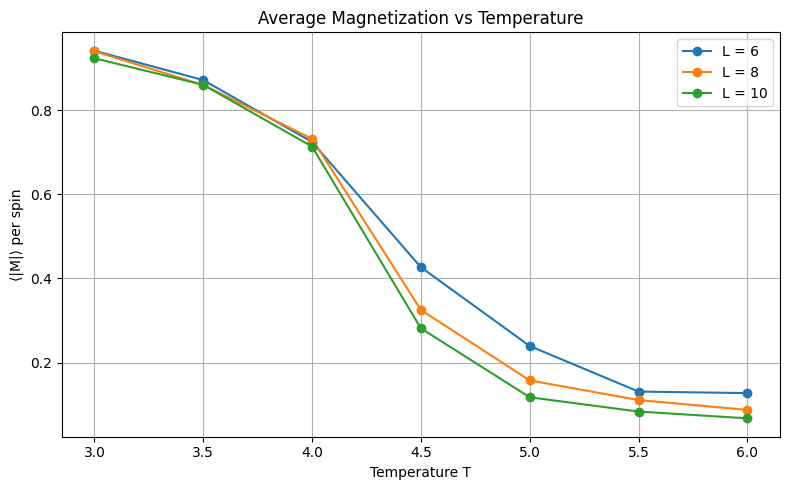

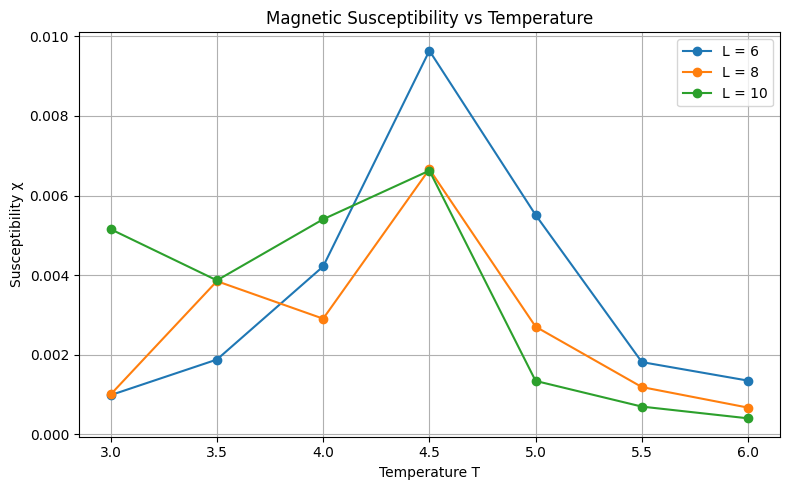

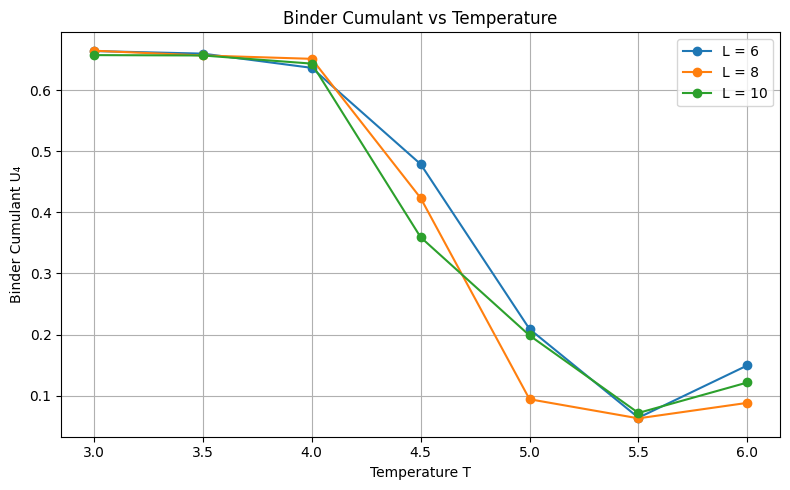

In [ ]:
L_values = [6, 8, 10]
temperatures = np.linspace(3.0, 6.0, 7)
steps = 800
J = 1

# Store results per L
all_magnetizations = {}
all_susceptibilities = {}
all_binders = {}

# Run simulations
for L in L_values:
    avg_mags = []
    susceptibilities = []
    binders = []

    print(f"\n=== Simulating for L = {L} ===")
    for T in temperatures:
        print(f"  T = {T:.2f}")
        result = simulate_ising(L, T, steps=steps, J=J)

        avg_mags.append(result['avg_magnetization'])
        susceptibilities.append(result['susceptibility'])
        binders.append(result['binder_cumulant'])

    all_magnetizations[L] = avg_mags
    all_susceptibilities[L] = susceptibilities
    all_binders[L] = binders

# Plot 1: Average Magnetization vs Temperature
plt.figure(figsize=(8, 5))
for L in L_values:
    plt.plot(temperatures, all_magnetizations[L], marker='o', label=f"L = {L}")
plt.title("Average Magnetization vs Temperature")
plt.xlabel("Temperature T")
plt.ylabel("⟨|M|⟩ per spin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Susceptibility vs Temperature
plt.figure(figsize=(8, 5))
for L in L_values:
    plt.plot(temperatures, all_susceptibilities[L], marker='o', label=f"L = {L}")
plt.title("Magnetic Susceptibility vs Temperature")
plt.xlabel("Temperature T")
plt.ylabel("Susceptibility χ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Binder Cumulant vs Temperature
plt.figure(figsize=(8, 5))
for L in L_values:
    plt.plot(temperatures, all_binders[L], marker='o', label=f"L = {L}")
plt.title("Binder Cumulant vs Temperature")
plt.xlabel("Temperature T")
plt.ylabel("Binder Cumulant U₄")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Simulation 2: With Thermalization


To improve the reliability of the results, the second set of simulations is carried out under the same conditions as the first, but now includes a thermalization phase. Initial Monte Carlo sweeps are discarded to allow the system to reach equilibrium before measurements are taken.

This approach increases computational cost but yields more accurate estimates of thermodynamic quantities. In particular, we expect reduced noise in the magnetization, clearer peaks in susceptibility, and more consistent Binder cumulant crossings. These improvements are especially important near the critical temperature, where fluctuations are large and convergence is slow.

In [ ]:
def simulate_ising_with_thermalization_steps(L, T, steps=800, thermalization_steps=200, J=1):
    """
    Run an Ising model simulation and record magnetization, energy, susceptibility, and Binder cumulant.

    Parameters:
        L (int): lattice size (LxLxL cube)
        T (float): temperature
        steps (int): number of total Monte Carlo sweeps used for measurements (after thermalization)
        thermalization_steps (int): number of sweeps before measurements begin
        J (float): interaction constant

    Returns:
        results (dict): dictionary with average and std of energy, magnetization, susceptibility, and Binder cumulant
    """
    lattice = initialize_lattice(L)
    N = L**3  # Total number of spins

    # Thermalization phase (no measurements taken)
    for _ in range(thermalization_steps):
        metropolis_sweep(lattice, T, J)

    # Measurement phase
    energies = []
    magnetizations = []

    for _ in range(steps):
        metropolis_sweep(lattice, T, J)
        E = compute_total_energy(lattice, J) / N  # normalize per spin
        M = compute_magnetization(lattice)       # signed magnetization per spin

        energies.append(E)
        magnetizations.append(M)

    # Compute derived quantities
    avg_E = np.mean(energies)
    std_E = np.std(energies)

    avg_M = np.mean(np.abs(magnetizations))  # usually use abs for symmetry
    std_M = np.std(magnetizations)

    chi = compute_susceptibility(magnetizations, T)
    binder = compute_binder_cumulant(magnetizations)

    return {
        'avg_energy': avg_E,
        'std_energy': std_E,
        'avg_magnetization': avg_M,
        'std_magnetization': std_M,
        'susceptibility': chi,
        'binder_cumulant': binder,
        'energies': energies,
        'magnetizations': magnetizations
    }



=== Simulating for L = 6 ===
  T = 3.00
  T = 3.50
  T = 4.00
  T = 4.50
  T = 5.00
  T = 5.50
  T = 6.00

=== Simulating for L = 8 ===
  T = 3.00
  T = 3.50
  T = 4.00
  T = 4.50
  T = 5.00
  T = 5.50
  T = 6.00

=== Simulating for L = 10 ===
  T = 3.00
  T = 3.50
  T = 4.00
  T = 4.50
  T = 5.00
  T = 5.50
  T = 6.00


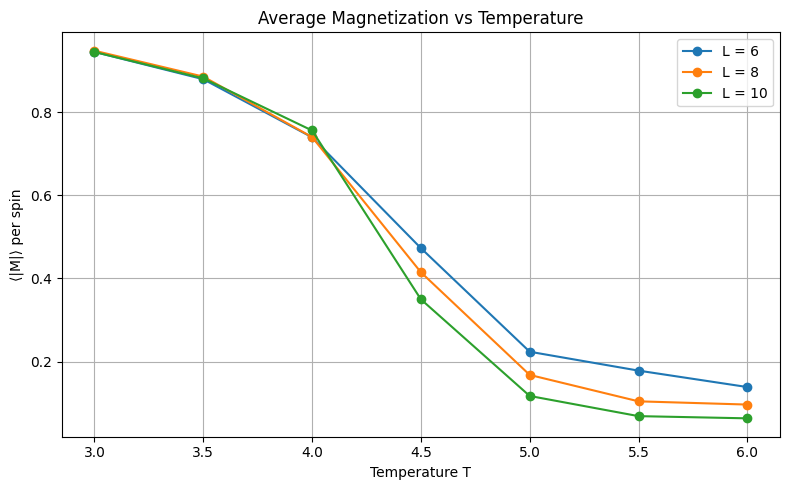

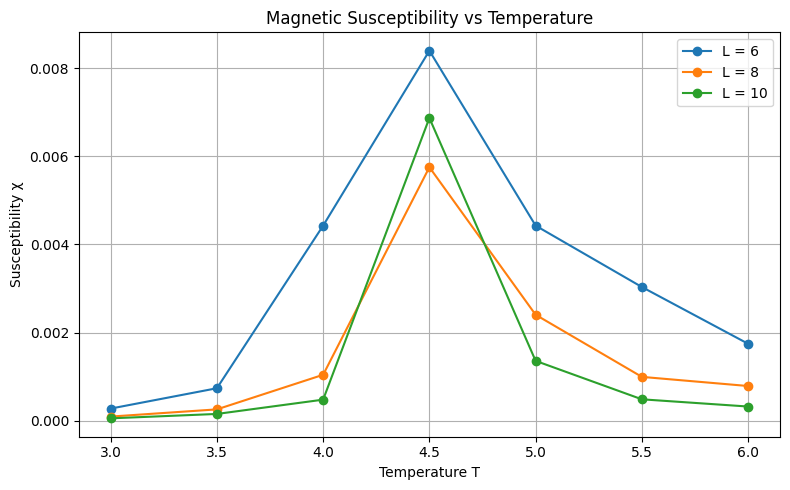

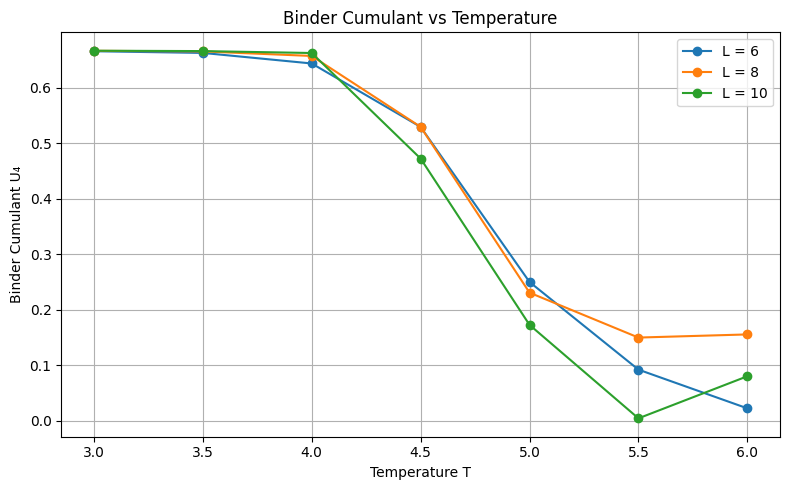

In [ ]:
# Parameters
L_values = [6, 8, 10]
temperatures = np.linspace(3.0, 6.0, 7)
steps = 800
thermalization_steps = 200
J = 1

# Store results per L
all_magnetizations = {}
all_susceptibilities = {}
all_binders = {}

# Run simulations
for L in L_values:
    avg_mags = []
    susceptibilities = []
    binders = []

    print(f"\n=== Simulating for L = {L} ===")
    for T in temperatures:
        print(f"  T = {T:.2f}")
        result = simulate_ising_with_thermalization_steps(L, T, steps=steps, thermalization_steps=thermalization_steps, J=J)

        avg_mags.append(result['avg_magnetization'])
        susceptibilities.append(result['susceptibility'])
        binders.append(result['binder_cumulant'])

    all_magnetizations[L] = avg_mags
    all_susceptibilities[L] = susceptibilities
    all_binders[L] = binders

# Plot 1: Average Magnetization vs Temperature
plt.figure(figsize=(8, 5))
for L in L_values:
    plt.plot(temperatures, all_magnetizations[L], marker='o', label=f"L = {L}")
plt.title("Average Magnetization vs Temperature")
plt.xlabel("Temperature T")
plt.ylabel("⟨|M|⟩ per spin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Susceptibility vs Temperature
plt.figure(figsize=(8, 5))
for L in L_values:
    plt.plot(temperatures, all_susceptibilities[L], marker='o', label=f"L = {L}")
plt.title("Magnetic Susceptibility vs Temperature")
plt.xlabel("Temperature T")
plt.ylabel("Susceptibility χ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Binder Cumulant vs Temperature
plt.figure(figsize=(8, 5))
for L in L_values:
    plt.plot(temperatures, all_binders[L], marker='o', label=f"L = {L}")
plt.title("Binder Cumulant vs Temperature")
plt.xlabel("Temperature T")
plt.ylabel("Binder Cumulant U₄")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis and Interpretation


Both simulations provide valuable insights into the behavior of the 3D Ising model near the phase transition. While the simulation without thermalization captures the overall shape of key thermodynamic curves, the version with thermalization shows significantly cleaner and more consistent trends.

In both cases, the observables reflect signatures of critical behavior, but these features are more sharply resolved in the thermalized simulation:

- **Magnetization decay across $T_c$**: The magnetization decreases with temperature and exhibits a sharp drop near $T \approx 4.5$ in both simulations, signaling the loss of magnetic order. This behavior is even more pronounced in the earlier full simulation on larger lattices ($L = 10, 15, 20$), where the transition appears sharper due to reduced finite-size effects.

- **Peaks in susceptibility**: Both simulations show that the magnetic susceptibility reaches a maximum near $T \approx 4.5$, corresponding to increased fluctuations in magnetization and thus highlighting a phase transitions. In the thermalized case, these peaks are more pronounced and align better across different lattice sizes, making the critical region easier to identify.

- **Crossings in Binder cumulant curves**: The Binder cumulant exhibits a crossing point near $T \approx 4.5$ in both simulations, providing a size-independent estimate of the critical temperature. The crossings appear sharper and more localized in the thermalized results, which improves the precision of $T_c$ estimation.

Both sets of results contribute to the estimation of the critical temperature $T_c$. Despite its limitations, the non-thermalized simulation still supports an estimate near $T \approx 4.5$, although with more noise and greater finite-size sensitivity. The thermalized data reinforces this estimate with higher clarity and consistency.

In summary, **both simulations identify the location of the phase transition**, validating $T_c \approx 4.5$ as a consistent result. Thermalization enhances the resolution and statistical reliability of this estimate, but the core physical conclusions remain robust in both approaches.




# Conclusions

In this project, we implemented a Monte Carlo simulation of the 3D Ising model using the Metropolis algorithm and investigated its behavior across a range of temperatures and system sizes. Our analysis focused on three key thermodynamic observables: **magnetization**, **magnetic susceptibility**, and the **Binder cumulant**, each offering distinct insights into the nature of the phase transition. To complement this analysis, we also generated static and animated visualizations of the 3D spin lattice, providing an intuitive representation of spin configurations and their evolution.

We observed that the **average magnetization** decreases sharply as temperature increases, indicating a transition from a ferromagnetic phase to a paramagnetic one. This transition became progressively sharper with increasing lattice size, reflecting the system’s approach to the thermodynamic limit.

The **magnetic susceptibility** exhibited a pronounced peak near the critical temperature, corresponding to large fluctuations in magnetization. As expected, the height and sharpness of this peak increased with system size, in agreement with finite-size scaling theory for second-order phase transitions.

The **Binder cumulant** curves for different lattice sizes showed a clear crossing point near $T_c \approx 4.5$, providing a robust, size-independent estimate of the critical temperature. This confirms the Binder cumulant’s effectiveness as a diagnostic tool for locating phase transitions in finite systems.

Overall, our simulations successfully captured the key features of the 3D Ising model and provided a consistent estimate of the critical temperature. These results highlight the power of numerical approaches in studying statistical systems where exact analytical solutions are not available.

